Multistage neural operator with inverse

First derivative, 3-layer CNN, relu activation, multistage

In [135]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime

In [136]:
save = False
cluster = False

In [137]:
torch.cuda.is_available()

True

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [139]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [140]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        first_derivatives = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # Ensure f(0) = 0
            y_0 = self.complex_fourier_series(torch.tensor([0.0]), c)
            y = y - y_0
            
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(first_derivatives), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000

# Uncomment below to create dataset
dataset = FourierSeriesDataset(num_samples, num_points)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
torch.save(dataset, 'datasets/standardized_dataset.pt')

## Load previously saved dataset

In [141]:
dataset = torch.load('datasets/standardized_dataset.pt')

In [142]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [143]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [144]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


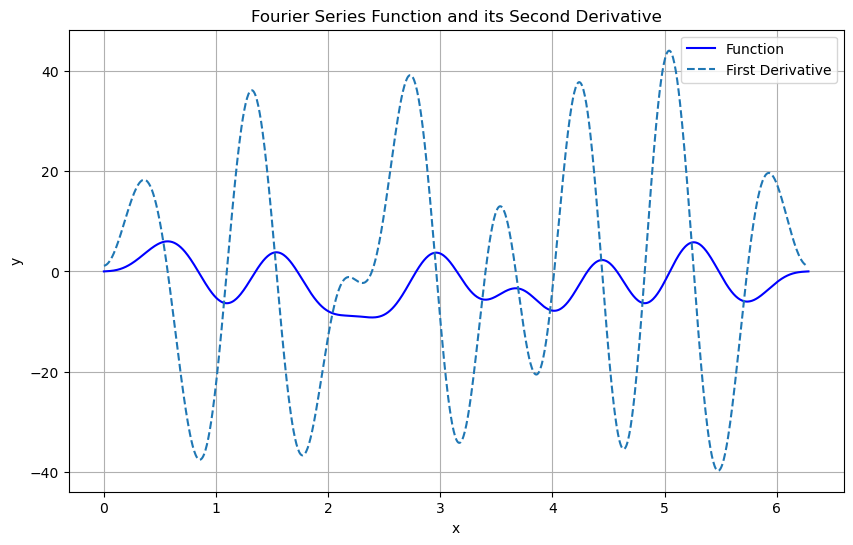

In [145]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative, second_derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()
    second_derivative = second_derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    # plt.plot(x, second_derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset, shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

This version of the CNN uses three layers.

In [146]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

f0 = SimpleCNN()
criterion = nn.MSELoss()

In [147]:
# to use model from cluster, use
# f0.load_state_dict(torch.load('models/f0_E1000.pth'))

## Training loop

In [148]:
train_losses, test_losses = [], []

def model_training(model, num_epochs, lr_factor=1, order=None):
    train_losses = []
    test_losses = []

    lr = 1e-3 / lr_factor

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, _ in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, _ in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order}st derivative")
    return train_losses, test_losses

**Uncomment below to train and save the model**


In [149]:
train_losses, test_losses = model_training(f0, 1000, order='first')
torch.save(f0.state_dict(), 'models/f0_E1000.pth')

Epoch [1/5], Train Loss: 66.0334, Test Loss: 0.8367
Epoch [2/5], Train Loss: 1.0948, Test Loss: 0.5448
Epoch [3/5], Train Loss: 0.5151, Test Loss: 0.4389
Epoch [4/5], Train Loss: 0.6160, Test Loss: 0.3742
Epoch [5/5], Train Loss: 0.9673, Test Loss: 0.3344
Training finished for firstst derivative


In [150]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

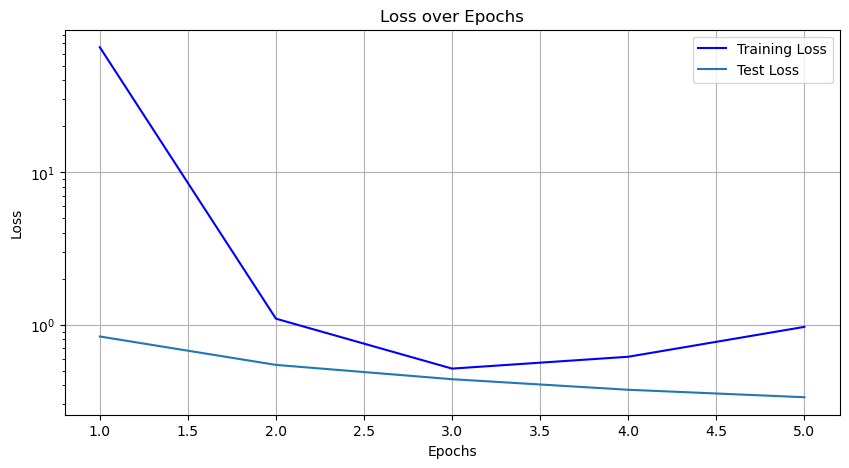

In [151]:
plot_losses(train_losses=train_losses, test_losses=test_losses,\
    save_dir='plots/multistage', filename='f0_E1000_loss', save=save)

In [152]:
def plot_output(model1, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset=train_dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative, true_second_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        predicted_derivative = model1(function)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()
    true_second_derivative = true_second_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')
    if order == 2:
        plt.plot(x, true_second_derivative, label=f'True {order}nd derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

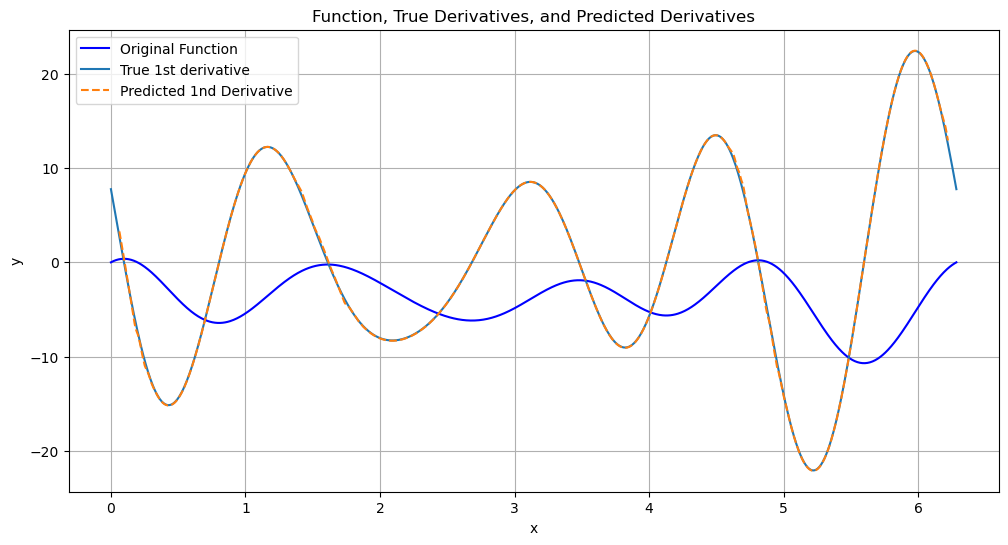

In [153]:
plot_output(f0, order=1, save_dir='multistage', filename='f0_E1000_output', save=save)

## Calculate accuracy (MSE)

MSE is computed as: $\frac{1}{n} \sum (y-f(x))^2$

In [154]:
def calculate_combined_output(model1, model2, function_input, true_derivative):
    # Predict the derivative from the first model
    output = model1(function_input)

    # Compute the residual and root mean squared error
    residual = output.squeeze() - true_derivative
    rms = torch.sqrt(torch.mean(residual**2))

    # Predict the derivative from the second model
    output2 = model2(function_input)

    # Calculate the combined model output
    combined_model_output = output + rms * output2

    return combined_model_output

In [155]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv, _ in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

print(f"MSE over all test functions: {compute_mse(test_dataloader, f0)[0]}")
print(f"NMSE over all test functions: {compute_mse(test_dataloader, f0)[1]}")

MSE over all test functions: 0.3343532681465149
NMSE over all test functions: 0.0013987882994115353


## Normalized MSE

NMSE is computed as: $\frac{1}{n} \frac{\sum (y-f(x))^2}{\sum y^2}$

## Spectral biases from Fourier Transform

In [156]:
def calculate_median_frequency(function):
    fft_coeffs = np.fft.fft(function)
    freqs = np.fft.fftfreq(len(function))
    power_spectrum = np.abs(fft_coeffs)**2
    significant_freqs = freqs[power_spectrum > (np.max(power_spectrum) * 0.01)]
    return np.median(np.abs(significant_freqs))

def categorize_functions(dataloader):
    functions_with_freqs = []
    
    for functions, derivatives, sec_derivative in dataloader:
        for idx, function in enumerate(functions):
            median_frequency = calculate_median_frequency(function.numpy())
            functions_with_freqs.append((function.numpy(), derivatives[idx].numpy(), sec_derivative[idx].numpy(), median_frequency))
    
    # Sort by median frequency
    functions_with_freqs.sort(key=lambda x: x[3])
    
    # Split into low and high frequency datasets
    mid_index = len(functions_with_freqs) // 2
    low_freq_dataset = functions_with_freqs[:mid_index]
    high_freq_dataset = functions_with_freqs[mid_index:]
    
    # Create new DataLoaders, excluding the median frequency from the data
    # Each dataloader contains the function, deriv, and second deriv
    low_freq_dataloader = [(f[0], f[1], f[2]) for f in low_freq_dataset]
    high_freq_dataloader = [(f[0], f[1], f[2]) for f in high_freq_dataset]
    
    return low_freq_dataloader, high_freq_dataloader

In [157]:
# use the test dataset to compute frequencies
# Should be half of full dataset in each dataloader
low_freq_dataset, high_freq_dataset = categorize_functions(test_dataloader)

print(f"Low frequency dataset size: {len(low_freq_dataset)}")
print(f"High frequency dataset size: {len(high_freq_dataset)}")

low_freq_dataloader = DataLoader(low_freq_dataset, batch_size=32, shuffle=True)
high_freq_dataloader = DataLoader(high_freq_dataset, batch_size=32, shuffle=True)

Low frequency dataset size: 992
High frequency dataset size: 992


In [158]:
print(f"MSE over low freq functions: {compute_mse(low_freq_dataloader, f0)[0]}")
print(f"NMSE over low freq functions: {compute_mse(low_freq_dataloader, f0)[1]}")

MSE over low freq functions: 0.07019998878240585
NMSE over low freq functions: 0.001388107193633914


In [159]:
print(f"MSE over high freq functions: {compute_mse(high_freq_dataloader, f0)[0]}")
print(f"NMSE over high freq functions: {compute_mse(high_freq_dataloader, f0)[1]}")

MSE over high freq functions: 0.5985065698623657
NMSE over high freq functions: 0.0014000518713146448


### Plotting errors

In [160]:
def plot_difference(model1, dataset, save_dir='plots', filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode
    
    current_date = datetime.now().strftime("%m-%d")

    def plot_sliced(x, y, label, linestyle='-'):
        plt.plot(x[10:-10], y[10:-10], label=label, linestyle=linestyle)

    plt.figure(figsize=(12, 12))  # Adjust figure size for a 2x2 grid
    
    for i in range(1, 5):  # Loop over four different functions
        train_dataloader_viz = get_random_function(dataset, shuffle=True)
        dataiter = iter(train_dataloader_viz)
        function, true_derivative, true_second_derivative = next(dataiter)

        function = function.unsqueeze(1)  # Add channel dimension

        # Make prediction
        with torch.no_grad():
            predicted_derivative = model1(function)
            first_deriv_diff = true_derivative - predicted_derivative

            predicted_second_derivative = model1(predicted_derivative)
            second_deriv_diff = true_second_derivative - predicted_second_derivative

        # Convert tensors to numpy arrays for plotting
        x = torch.linspace(0, 2*torch.pi, 1000).numpy()
        function = function.squeeze().numpy()
        true_derivative = true_derivative.squeeze().numpy()
        true_second_derivative = true_second_derivative.squeeze().numpy()
        
        first_deriv_diff = first_deriv_diff.squeeze().numpy()
        second_deriv_diff = second_deriv_diff.squeeze().numpy()

        plt.subplot(2, 2, i)  # Adjust subplot position
        plot_sliced(x, function, '$u$')
        plot_sliced(x, first_deriv_diff, "$u'_g - u'_{\\theta}$", linestyle='--')
        # plot_sliced(x, true_derivative, "$u'_g$")
        # plot_sliced(x, true_second_derivative, "$u''_g$", linestyle='--')

        plt.title(f'Difference for Function {i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        mse = np.mean((first_deriv_diff) ** 2)
        nmse = mse / np.mean(true_derivative ** 2)

        print(f"MSE for function {i} is: {mse}")        
        print(f"NMSE for function {i} is: {nmse}\n")        
    
    if save:
        filename = f"{filename}_{current_date}.png"
        save_path = os.path.join(save_dir, filename if filename else 'multi_plot.png')
        plt.savefig(save_path)
    plt.show()


In [161]:
def plot_difference_separate(model1, dataset, save_dir='plots', filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model1.eval()  # Set the model to evaluation mode

    def plot_sliced(x, y, label, linestyle='-'):
        plt.plot(x[10:-10], y[10:-10], label=label, linestyle=linestyle)

    current_date = datetime.now().strftime("%m-%d")

    plt.figure(figsize=(12, 6*4))  # Adjust figure size for side-by-side plots
    
    for i in range(1, 5):  # Loop over four different functions
        train_dataloader_viz = get_random_function(dataset, shuffle=True)
        dataiter = iter(train_dataloader_viz)
        function, true_derivative, true_second_derivative = next(dataiter)

        function = function.unsqueeze(1)  # Add channel dimension

        # Make prediction
        with torch.no_grad():
            predicted_derivative = model1(function)
            first_deriv_diff = true_derivative - predicted_derivative

            predicted_second_derivative = model1(predicted_derivative)
            second_deriv_diff = true_second_derivative - predicted_second_derivative

        # Convert tensors to numpy arrays for plotting
        x = torch.linspace(0, 2*torch.pi, 1000).numpy()
        function = function.squeeze().numpy()
        true_derivative = true_derivative.squeeze().numpy()
        true_second_derivative = true_second_derivative.squeeze().numpy()
        
        first_deriv_diff = first_deriv_diff.squeeze().numpy()
        second_deriv_diff = second_deriv_diff.squeeze().numpy()

        # Plot original function and its derivative
        plt.subplot(4, 2, 2*i-1)  # Adjust subplot position for original function
        plot_sliced(x, function, '$u$', linestyle='-')
        # plot_sliced(x, true_derivative, "$u'$", linestyle='--')
        plt.title(f'Function {i} and its derivative')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        # Plot difference (error)
        plt.subplot(4, 2, 2*i)  # Adjust subplot position for difference plot
        plot_sliced(x, first_deriv_diff, "$u'_g - u'_{\\theta}$", linestyle='--')
        plt.title(f'Error in derivative for Function {i}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)

        mse = np.mean((first_deriv_diff) ** 2)
        nmse = mse / np.mean(true_derivative ** 2)

        print(f"MSE for function {i} is: {mse}")        
        print(f"NMSE for function {i} is: {nmse}\n")        

    if save:
        filename = f"{filename}_{current_date}.png"
        save_path = os.path.join(save_dir, filename if filename else 'multi_plot.png')
        plt.savefig(save_path)
    plt.show()


## Inverse model training (going from u' to u)

In [162]:
g0 = SimpleCNN()

inverse_model will be trained using ground truth derivatives u_g'

In [163]:
# Training loop
train_losses, test_losses = [], []
def inverse_model_training(model, train_dataloader, test_dataloader, num_epochs, order=None):
    train_losses = []
    test_losses = []

    # dataloader should be function_derivative_pairs

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for functions, model_derivatives, _ in train_dataloader:
            functions = functions.detach().unsqueeze(1)
            model_derivatives = model_derivatives.detach().unsqueeze(1)

            # We want this model to be the inverse model now: compute original function
            outputs = model(model_derivatives).squeeze()
            functions = functions.squeeze()
            loss = criterion(outputs, functions)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for test_functions, test_model_derivatives, _ in test_dataloader:
                test_functions = test_functions.detach().unsqueeze(1)
                test_model_derivatives = test_model_derivatives.detach().unsqueeze(1)

                outputs = model(test_model_derivatives).squeeze()
                test_functions = test_functions.squeeze()
                
                loss = criterion(outputs, test_functions)
                test_loss += loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")
    return train_losses, test_losses

In [164]:
train_losses, test_losses = inverse_model_training(g0, train_dataloader,\
    test_dataloader, 1000, order='first')

Epoch [1/5], Train Loss: 18.4220, Test Loss: 17.8547
Epoch [2/5], Train Loss: 17.3154, Test Loss: 17.5541
Epoch [3/5], Train Loss: 16.9356, Test Loss: 16.8129
Epoch [4/5], Train Loss: 16.9121, Test Loss: 17.2666
Epoch [5/5], Train Loss: 16.5214, Test Loss: 16.5441
Training finished for first derivative


In [165]:
torch.save(g0.state_dict(), 'models/g0_E1000.pth')

In [166]:
g0.load_state_dict(torch.load('models/g0_E1000.pth'))

<All keys matched successfully>

In [167]:
def compute_inverse_mse(dataloader, model):
    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(deriv)
        all_targets.append(function)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)
    # print(f"Overall MSE over all test functions: {mse.item()}")

    return mse.item(), nmse.item()

print(f"Train MSE: {compute_mse(train_dataloader, g0)[0]},\
    Train NMSE: {compute_mse(train_dataloader, g0)[1]}")

print(f"Test MSE: {compute_mse(test_dataloader, g0)[0]},\
    Test NMSE: {compute_mse(test_dataloader, g0)[1]}")

Train MSE: 263.6260070800781,    Train NMSE: 1.085357904434204
Test MSE: 259.42132568359375,    Test NMSE: 1.0853056907653809


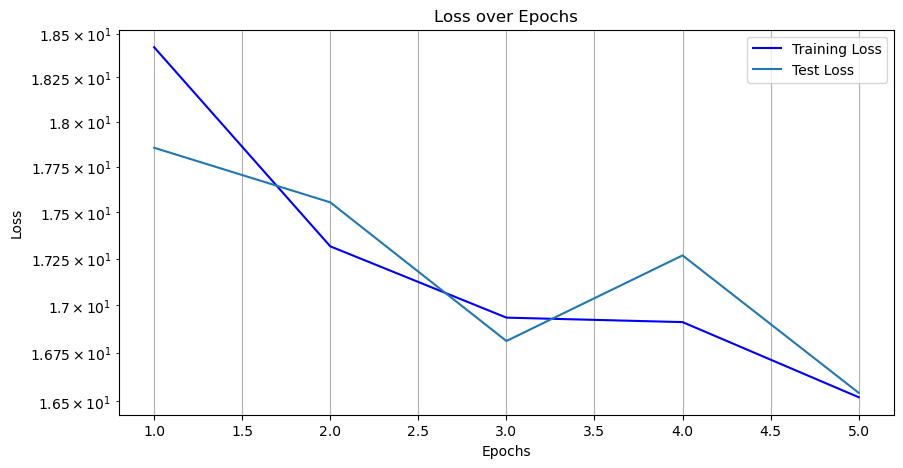

In [168]:
plot_losses(train_losses=train_losses, test_losses=test_losses,\
    save_dir='plots/multistage', filename='g0_E1000_loss', save=save)

In [169]:
def plot_output(model, order=None, save_dir='plots', filename=None, save=False): 
    model.eval()  # Set the model to evaluation mode

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")

    dataiter = iter(function_derivative_pairs_test)
    function_batch, deriv_batch = next(dataiter)
    function, deriv = function_batch[0], deriv_batch[0]

    # Reshape the input for the model
    deriv = deriv.unsqueeze(0)
    print(f"deriv shape: {deriv.shape}")

    # Make prediction
    with torch.no_grad():
        predicted_function = model(deriv)

    deriv = deriv.squeeze().detach().numpy()
    print(f"deriv shape: {deriv.shape}")


    predicted_function = predicted_function.squeeze().numpy()
    print(f"function shape: {function.shape}")
    
    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()


    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x, function, label='Original Function', color='blue')
    plt.plot(x, deriv, label=f'Predicted {order}st derivative')
    plt.plot(x[10:-10], predicted_function[10:-10], label=f'Predicted function', linestyle='--')

    plt.title('Function and inverse function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

deriv shape: torch.Size([1, 1000])
deriv shape: (1000,)
function shape: torch.Size([1000])


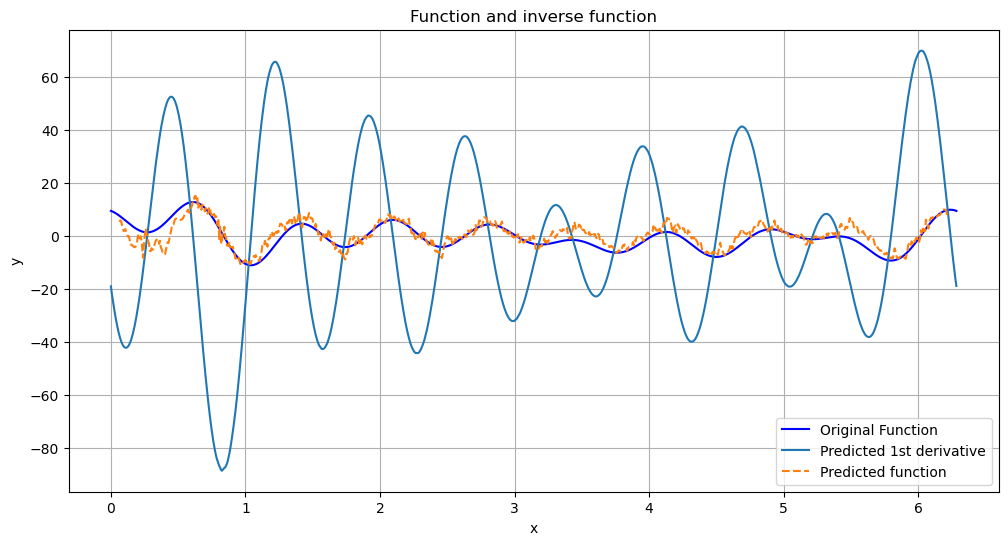

In [170]:
plot_output(inverse_model, order=1, save_dir='plots/multistage', filename='g0_E1000_output', save=save)

## Second stage training based on inverse residue

Need to create a new dataset consisting of $(u_g, (u_g-u_w))$ and train a second stage model that takes as input $(u_g, (u_g-u_w))$ and minimizes $\frac{(u_g-u_w)}{RMS(u_g-u_w)}$